In [15]:
from model.VAE_model import *
from model.Function import *
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from model.expVAE import * 

In [16]:
class Args:
  pass

args = Args()
args.batch_size = 50
args.epochs = 200
args.cuda = True
args.log_interval = 10
args.model = 'optimal_sigma_vae'  # Which model to use:  mse_vae,  gaussian_vae, or sigma_vae or optimal_sigma_vae

if not torch.cuda.is_available():
  args.cuda = False
device = torch.device("cuda" if args.cuda else "cpu")

In [62]:
model = ConvVAE(device, 3, args).to(device)
model.load_state_dict(torch.load("./model/save/sigmaVAE_twostage_1.pt"))

<All keys matched successfully>

#### Image reconstruction

In [63]:
image_list = DataLoader(image_data("./data/Examples_CNN/"), batch_size=5)
image_list = next(iter(image_list))

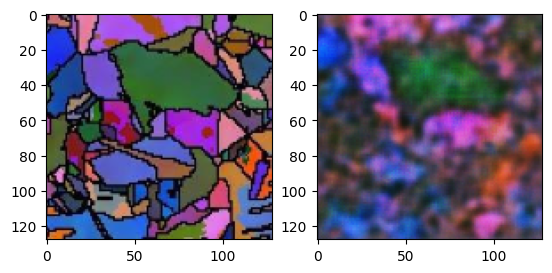

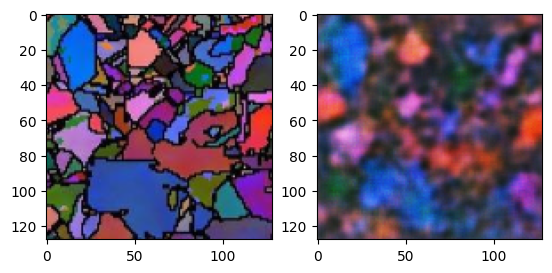

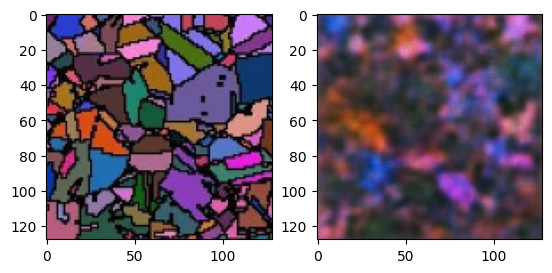

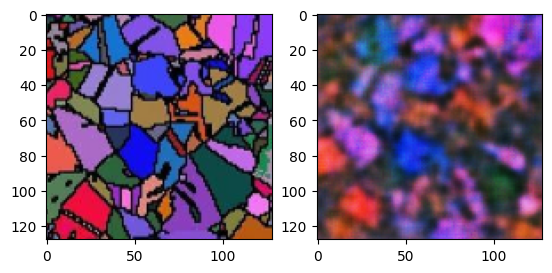

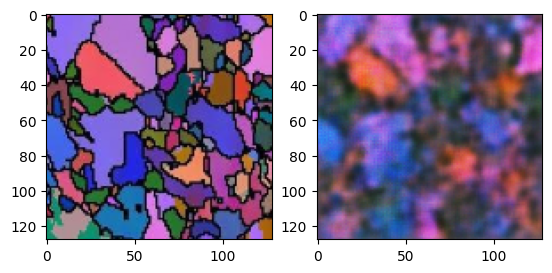

In [64]:
plt.figure()
for i in range(5):
    image = image_list[i]
    image_np = np.transpose(image, [1, 2, 0])
    mu, logvar = model.encode(image[np.newaxis, :])
    z1 = model.reparameterize(mu, logvar)
    image_gen = model.decode(z1)
    image_gen = image_gen.detach().numpy().reshape(3, 128,128)
    image_gen = np.transpose(image_gen, [1, 2, 0])


    plt.subplot(1,2,1)
    plt.imshow(image_np, cmap='Greys_r')#, cmap='Greys_r'
    plt.subplot(1,2,2)
    plt.imshow(image_gen, cmap='Greys_r')
    plt.show()

#### Image restoration

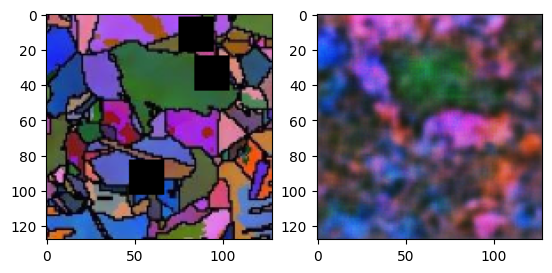

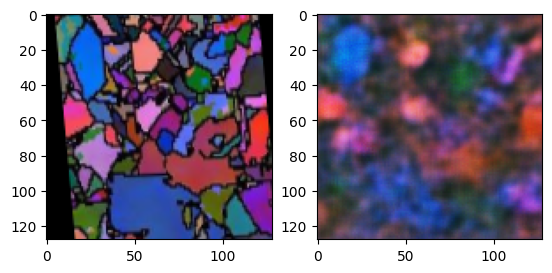

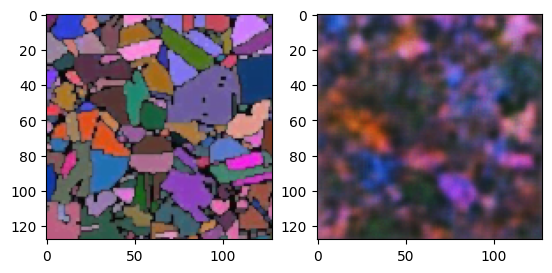

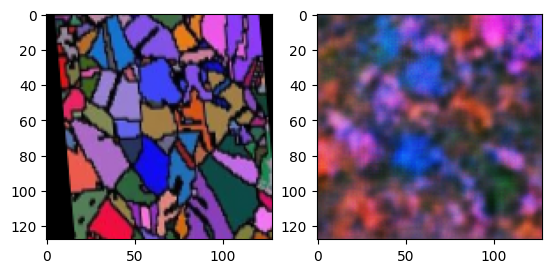

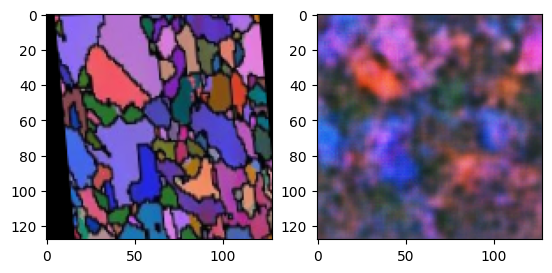

In [68]:
plt.figure()
for i in range(5):
    image = imgextend_2(image_list)[i]
    image_np = np.transpose(image, [1, 2, 0])
    mu, logvar = model.encode(image[np.newaxis, :])
    z1 = model.reparameterize(mu, logvar)
    image_gen = model.decode(z1)
    image_gen = image_gen.detach().numpy().reshape(3, 128,128)
    image_gen = np.transpose(image_gen, [1, 2, 0])


    plt.subplot(1,2,1)
    plt.imshow(image_np, cmap='Greys_r')#, cmap='Greys_r'
    plt.subplot(1,2,2)
    plt.imshow(image_gen, cmap='Greys_r')
    plt.show()

#### Distribution of latent variable

/Users/liaoweijie/anaconda3/envs/pt2x/lib/python3.9/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/liaoweijie/anaconda3/envs/pt2x/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/liaoweijie/anaconda3/envs/pt2x/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context(

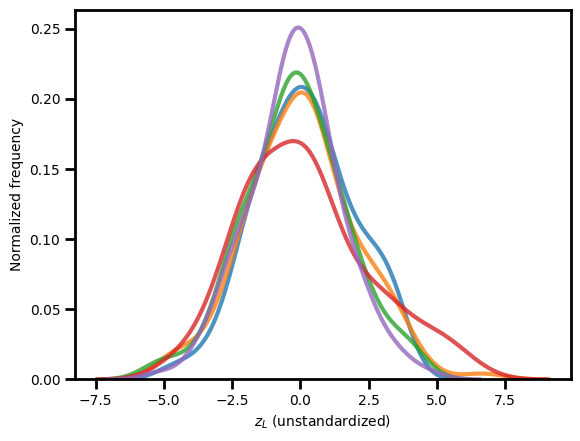

In [85]:
import seaborn as sns
plt.figure()
for i in range(5):
    image = image_list[i]
    image_np = np.transpose(image, [1, 2, 0])
    mu, logvar = model.encode(image[np.newaxis, :])
    z1 = model.reparameterize(mu, logvar)
    sns.kdeplot(z1.detach().numpy().squeeze(0), alpha=0.8, linewidth=3)
plt.xlabel("$z_L$ (unstandardized)")
plt.ylabel("Normalized frequency")
plt.legend(loc='best', frameon=False)
plt.tick_params(length=7, width=2)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.show()

#### Interpretable analysis

In [70]:
def save_cam(image, filename, gcam):
    gcam = gcam - np.min(gcam)
    gcam = gcam / np.max(gcam)
    h, w, d = image.shape
    gcam = cv2.resize(gcam, (w, h))
    gcam = cv2.applyColorMap(np.uint8(255 * gcam), cv2.COLORMAP_JET)
    gcam = np.asarray(gcam, dtype=np.float32) + np.asarray(image, dtype=np.float32)
    gcam = 255 * gcam / np.max(gcam)
    gcam = np.uint8(gcam)
    cv2.imwrite(filename, gcam)

In [71]:
image_list = DataLoader(image_data("./data/Examples_Disentanglment/"), batch_size=5)
image_list = next(iter(image_list))

/Users/liaoweijie/anaconda3/envs/pt2x/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [75]:
gcam = GradCAM(model, target_layer='encoder.4', unmask=0, z_dim=128, cuda=False, Anomaly_Detection=False, Disentanglement=True)

In [76]:
test_index=0
model.eval()
image_list = image_list.to(device)
x_rec, mu, logvar = gcam.forward(image_list)

model.zero_grad()
gcam.backward(mu, logvar, 0, 0)
gcam_map = gcam.generate()

## Visualize and save attention maps  ##
image_list = image_list.repeat(1, 1, 1, 1)
for i in range(image_list.size(0)):
    raw_image = image_list[i] * 255.0
    ndarr = raw_image.permute(1, 2, 0).cpu().byte().numpy()
    im = Image.fromarray(ndarr.astype(np.uint8))
    im_path = "./CAM/CAM_Disentanglement"
    if not os.path.exists(im_path):
        os.mkdir(im_path)
    im.save(os.path.join(im_path, "{}-origin.png".format(test_index)))
    file_path = os.path.join(im_path, "{}-attmap.png".format(test_index))
    r_im = np.asarray(im)
    save_cam(r_im, file_path, gcam_map[i].squeeze().cpu().data.numpy())
    test_index += 1

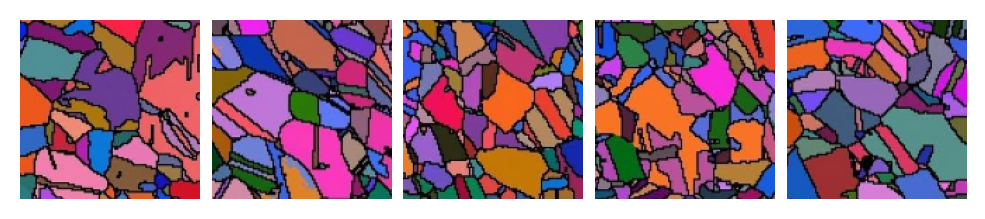

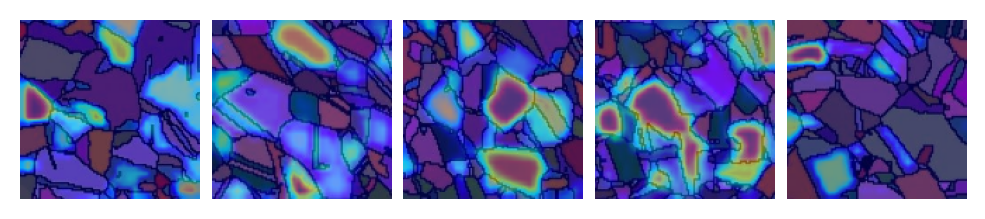

In [77]:
plt.figure(dpi=200)
for i in range(0, 5):
    img_path = "./CAM/CAM_Disentanglement/" + str(i) + "-origin.png"
    img = Image.open(img_path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.15,hspace=0.04)

plt.figure(dpi=200)
for i in range(0, 5):
    img_path = "./CAM/CAM_Disentanglement/" + str(i) + "-attmap.png"
    img = Image.open(img_path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.15,hspace=0.04)

#### Anomaly detection

In [7]:
class Args:
  pass

args = Args()
args.batch_size = 64
args.epochs = 5
args.cuda = True
args.log_interval = 10
args.model = 'optimal_sigma_vae'  # Which model to use:  mse_vae,  gaussian_vae, or sigma_vae or optimal_sigma_vae
args.result_dir = "CAM"
if not torch.cuda.is_available():
  args.cuda = False
device = torch.device("cuda" if args.cuda else "cpu")

model = ConvVAE(device, 3, args).to(device)
model.load_state_dict(torch.load("./model/save/sigmaVAE_min_1.pt"))#读取模型

<All keys matched successfully>

In [30]:
image_list = DataLoader(image_data("./data/Examples_anomaly/"), batch_size=5)
image_list = next(iter(image_list))

In [31]:
mu_avg = torch.load('./model/save/mu_avg.pt')
logvar_avg = torch.load('./model/save/logvar_avg.pt')

In [51]:
gcam = GradCAM(model, target_layer='encoder.4', cuda=False, Anomaly_Detection=True, Disentanglement=False)

In [52]:
test_index=0
model.eval()
image_list = image_list.to(device)
x_rec, mu, logvar = gcam.forward(image_list)

model.zero_grad()
gcam.backward(mu, logvar, mu_avg, logvar_avg)
gcam_map = gcam.generate()

## Visualize and save attention maps  ##
image_list = image_list.repeat(1, 1, 1, 1)
for i in range(image_list.size(0)):
    raw_image = image_list[i] * 255.0
    ndarr = raw_image.permute(1, 2, 0).cpu().byte().numpy()
    im = Image.fromarray(ndarr.astype(np.uint8))
    im_path = "./CAM/CAM_Anomaly"
    if not os.path.exists(im_path):
        os.mkdir(im_path)
    im.save(os.path.join(im_path, "{}-origin.png".format(test_index)))
    file_path = os.path.join(im_path, "{}-attmap.png".format(test_index))
    r_im = np.asarray(im)
    save_cam(r_im, file_path, gcam_map[i].squeeze().cpu().data.numpy())
    test_index += 1

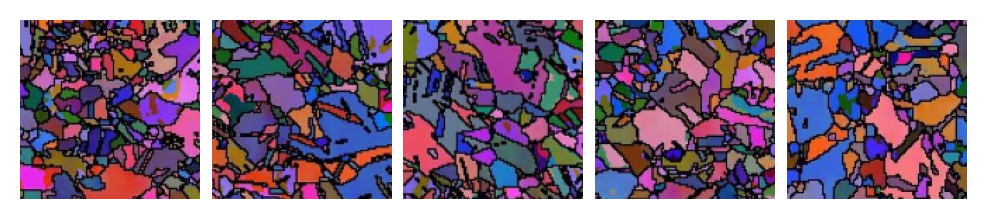

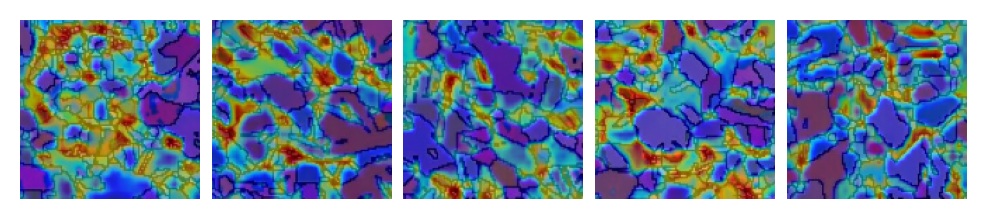

In [53]:
plt.figure(dpi=200)
for i in range(0, 5):
    img_path = "./CAM/CAM_Anomaly/" + str(i) + "-origin.png"
    img = Image.open(img_path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.15,hspace=0.04)

plt.figure(dpi=200)
for i in range(0, 5):
    img_path = "./CAM/CAM_Anomaly/" + str(i) + "-attmap.png"
    img = Image.open(img_path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.15,hspace=0.04)